<a href="https://colab.research.google.com/github/imartinez96/MLS_football_insight/blob/master/IrisMartinez_Football_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Finding MLS International Star Player**




#Introduction
In soccer, the glory goes to the top international league players.
Using detailed player data from FIFA '19, we will examine how MLS players match up against the top international league players. Then we take a closer look at players by examining individual attributes and their contribution to the overall player ratings. Hopefully after we will have a better idea of which players can potentially live up to the performance and fame of their international counterparts!



In [79]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels import api as sm

from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import xgboost as xgb

Data Taken from FIFA '19 Stats.  Dataset contains list of all soccer players and their skill ratings taken from FIFA 19 game. We can use these ratings and player attributes to determine what will be their Overall Rating.

In [2]:
all_df = pd.read_csv('data.csv')
all_df.head(10)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
5,5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,https://cdn.sofifa.org/teams/2/light/5.png,€93M,€340K,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,Yes,LF,10.0,"Jul 1, 2012",NaN,2020,5'8,163lbs,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,...,60+3,49+3,49+3,49+3,60+3,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M
6,6,177003,L. Modrić,32,https://cdn.so

In [3]:
all_df.shape

(18207, 89)

In [4]:
drop_cols = ['Unnamed: 0', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Body Type', 'Jersey Number', 'Joined', 'Loaned From', 'Flag', 'Club Logo',
             'Contract Valid Until', 'Photo']

all_df.drop(drop_cols, axis=1, inplace=True)
all_df.head(10)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Real Face,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Yes,RF,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,Yes,ST,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Yes,LW,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Yes,GK,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Yes,RCM,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
5,183277,E. Hazard,27,Belgium,91,91,Chelsea,€93M,€340K,2142,Right,4.0,4.0,4.0,High/ Medium,Yes,LF,5'8,163lbs,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M
6,177003,L. Modrić,32,Croatia,91,91,Real Madrid,€67M,€420K,2280,Right,4.0,4.0,4.0,High/ High,Yes,RCM,5'8,146lbs,86.0,72.0,55.0,93.0,76.0,90.0,85.0,78.0,88.0,93.0,80.0,72.0,93.0,90.0,94.0,79.0,68.0,89.0,58.0,82.0,62.0,83.0,79.0,92.0,82.0,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,€137.4M
7,176580,L. Suárez,31,Uruguay,91,91,FC Barcelona,€80M,€455K,2346,Right,5.0,4.0,3.0,High/ Medium,Yes,RS,6'0,190lbs,77.0,93.0,77.0,82.0,88.0,87.0,86.0,84.0,64.0,90.0,86.0,75.0,82.0,92.0,83.0,86.0,69.0,90.0,83.0,85.0,87.0,41.0,92.0,84.0,85.0,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,€164M
8,155862,Sergio Ramos,32,Spain,91,91,Real Madrid,€51M,€380K,2201,Right,4.0,3.0,3.0,High/ Medium,Yes,RCB,6'0,181lbs,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0,€104.6M
9,200389,J. Oblak,25,Slovenia,90,93,Atlético Madrid,€68M,€94K,1331,Right,3.0,3.0,1.0,Medium/ Medium,Yes,GK,6'2,192lbs,13.0,11.0,15.0,29.0,13.0,12.0,13.0,14.0,26.0,16.0,43.0,60.0,67.0,86.0,49.0,22.0,76.0,41.0,78.0,12.0,34.0,19.0,11.0,70.0,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M


In [ ]:
all_df.shape

(18207, 54)

In [5]:
pos_cat = {'RF': 'Forward', 'ST': 'Forward', 'LW': 'Forward','LF': 'Forward', 'RS': 'Forward','LS': 'Forward',
           'RW': 'Forward', 'CF': 'Forward', 'RCM': 'Midfielder','LCM': 'Midfielder','LDM': 'Midfielder', 
           'CAM':  'Midfielder', 'CDM': 'Midfielder','RM': 'Midfielder', 'LAM': 'Midfielder', 'LM': 'Midfielder',
           'RDM': 'Midfielder','CM': 'Midfielder','RAM': 'Midfielder','RCB': 'Defender','CB': 'Defender',
           'LCB': 'Defender','LB': 'Defender','RB': 'Defender','RWB': 'Defender', 'LWB': 'Defender', 'GK': 'Goalkeeper'}

all_df['Position_Cat'] = all_df['Position'].map(pos_cat)
all_df.head(10)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Real Face,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Position_Cat
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Yes,RF,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M,Forward
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,Yes,ST,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M,Forward
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Yes,LW,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M,Forward
3,193080,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Yes,GK,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M,Goalkeeper
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Yes,RCM,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M,Midfielder
5,183277,E. Hazard,27,Belgium,91,91,Chelsea,€93M,€340K,2142,Right,4.0,4.0,4.0,High/ Medium,Yes,LF,5'8,163lbs,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M,Forward
6,177003,L. Modrić,32,Croatia,91,91,Real Madrid,€67M,€420K,2280,Right,4.0,4.0,4.0,High/ High,Yes,RCM,5'8,146lbs,86.0,72.0,55.0,93.0,76.0,90.0,85.0,78.0,88.0,93.0,80.0,72.0,93.0,90.0,94.0,79.0,68.0,89.0,58.0,82.0,62.0,83.0,79.0,92.0,82.0,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,€137.4M,Midfielder
7,176580,L. Suárez,31,Uruguay,91,91,FC Barcelona,€80M,€455K,2346,Right,5.0,4.0,3.0,High/ Medium,Yes,RS,6'0,190lbs,77.0,93.0,77.0,82.0,88.0,87.0,86.0,84.0,64.0,90.0,86.0,75.0,82.0,92.0,83.0,86.0,69.0,90.0,83.0,85.0,87.0,41.0,92.0,84.0,85.0,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,€164M,Forward
8,155862,Sergio Ramos,32,Spain,91,91,Real Madrid,€51M,€380K,2201,Right,4.0,3.0,3.0,High/ Medium,Yes,RCB,6'0,181lbs,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0,€104.6M,Defender
9,200389,J. Oblak,25,Slovenia,90,93,Atlético Madrid,€68M,€94K,1331,Right,3.0,3.0,1.0,Medium/ Medium,Yes,GK,6'2,192lbs,13.0,11.0,15.0,29.0,13.0,12.0,13.0,14.0,26.0,16.0,43.0,60.0,67.0,86.0,49.0,22.0,76.0,41.0,78.0,12.0,34.0,19.0,11.0,70.0,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M,Goalkeeper


In [6]:
mls_teams = { 'Atlanta United', 'Chicago Fire', 'Colorado Rapids', 'Columbus Crew SC', 'DC United', 'FC Dallas',
             'Houston Dynamo','LA Galaxy','Los Angeles FC','Minnesota United FC', 'Montreal Impact',
             'New England Revolution', 'New York City FC','New York Red Bulls', 'Orlando City SC',
             'Philadelphia Union', 'Portland Timbers','Real Salt Lake', 'San Jose Earthquakes',
             'Seattle Sounders FC', 'Sporting Kansas City','Toronto FC', 'Vancouver Whitecaps FC'}

MLS_df = all_df[all_df['Club'].isin(mls_teams)]
MLS_df.head(10)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Real Face,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Position_Cat
109,41236,Z. Ibrahimović,36,Sweden,85,85,LA Galaxy,€14M,€15K,2012,Right,5.0,4.0,5.0,Medium/ Low,Yes,RS,6'5,209lbs,73.0,86.0,83.0,79.0,86.0,79.0,82.0,82.0,73.0,84.0,58.0,59.0,75.0,82.0,39.0,90.0,68.0,61.0,86.0,82.0,84.0,20.0,85.0,79.0,89.0,90.0,28.0,37.0,24.0,13.0,15.0,10.0,9.0,12.0,€21M,Forward
293,184431,S. Giovinco,31,Italy,82,82,Toronto FC,€20M,€15K,1957,Right,2.0,4.0,4.0,High/ Medium,Yes,CF,5'4,134lbs,72.0,80.0,34.0,80.0,75.0,86.0,90.0,93.0,76.0,86.0,88.0,80.0,94.0,80.0,91.0,80.0,34.0,77.0,42.0,81.0,75.0,26.0,82.0,81.0,73.0,82.0,23.0,29.0,28.0,6.0,3.0,6.0,3.0,3.0,€30M,Forward
315,113422,David Villa,36,Spain,82,82,New York City FC,€8M,€12K,1993,Right,3.0,5.0,4.0,High/ Low,Yes,ST,5'9,152lbs,71.0,86.0,67.0,76.0,79.0,83.0,83.0,80.0,67.0,85.0,72.0,67.0,71.0,83.0,73.0,81.0,67.0,70.0,66.0,79.0,67.0,29.0,86.0,75.0,88.0,83.0,30.0,28.0,38.0,8.0,9.0,9.0,11.0,9.0,€12M,Forward
345,207877,J. Martínez,25,Venezuela,81,84,Atlanta United,€22.5M,€14K,1917,Right,1.0,4.0,3.0,High/ Medium,Yes,LS,5'7,152lbs,53.0,84.0,77.0,68.0,73.0,75.0,68.0,57.0,55.0,78.0,89.0,92.0,91.0,79.0,90.0,79.0,86.0,72.0,73.0,65.0,66.0,20.0,84.0,58.0,70.0,75.0,20.0,20.0,15.0,12.0,14.0,14.0,12.0,8.0,€35.4M,Forward
397,169416,C. Vela,29,Mexico,81,81,Los Angeles FC,€17.5M,€15K,1986,Left,3.0,2.0,4.0,High/ Low,Yes,RW,5'10,170lbs,79.0,81.0,70.0,81.0,82.0,83.0,81.0,71.0,66.0,83.0,78.0,80.0,81.0,78.0,81.0,74.0,68.0,74.0,67.0,80.0,57.0,37.0,81.0,81.0,72.0,80.0,31.0,22.0,14.0,8.0,14.0,8.0,13.0,10.0,€26.3M,Forward
418,230977,M. Almirón,24,Paraguay,80,84,Atlanta United,€19.5M,€11K,1988,Left,1.0,2.0,4.0,High/ High,Yes,CAM,5'9,139lbs,71.0,74.0,43.0,79.0,75.0,81.0,74.0,70.0,70.0,79.0,90.0,89.0,86.0,79.0,64.0,78.0,46.0,85.0,52.0,73.0,65.0,50.0,74.0,79.0,64.0,76.0,43.0,53.0,49.0,6.0,9.0,13.0,13.0,12.0,€30.7M,Midfielder
524,176376,I. Piatti,33,Argentina,80,80,Montreal Impact,€9M,€13K,2074,Right,2.0,4.0,5.0,High/ Medium,Yes,LW,5'11,168lbs,69.0,81.0,54.0,78.0,77.0,86.0,80.0,55.0,74.0,84.0,77.0,76.0,87.0,82.0,81.0,83.0,31.0,89.0,73.0,80.0,79.0,55.0,83.0,77.0,80.0,82.0,61.0,62.0,24.0,14.0,13.0,7.0,7.0,15.0,€13.5M,Forward
528,172114,D. Valeri,32,Argentina,80,80,Portland Timbers,€11.5M,€12K,2009,Right,2.0,3.0,3.0,High/ Medium,Yes,RF,5'10,165lbs,78.0,80.0,70.0,79.0,75.0,78.0,80.0,79.0,76.0,82.0,62.0,60.0,72.0,80.0,73.0,85.0,68.0,82.0,63.0,84.0,53.0,36.0,84.0,82.0,79.0,83.0,39.0,40.0,30.0,15.0,15.0,8.0,10.0,12.0,€17.3M,Forward
550,121944,B. Schweinsteiger,33,Germany,80,80,Chicago Fire,€6M,€11K,2093,Right,4.0,3.0,3.0,Medium/ Medium,Yes,LCB,6'0,174lbs,76.0,69.0,75.0,82.0,79.0,71.0,82.0,74.0,83.0,78.0,36.0,37.0,61.0,81.0,63.0,81.0,71.0,67.0,75.0,77.0,77.0,77.0,73.0,81.0,77.0,87.0,76.0,74.0,75.0,14.0,14.0,13.0,13.0,11.0,€8.7M,Defender
552,54050,W. Rooney,32,England,80,80,DC United,€12M,€13K,2126,Right,4.0,4.0,3.0,Medium/ High,Yes,ST,5'9,183lbs,77.0,80.0,75.0,81.0,83.0,74.0,84.0,83.0,82.0,80.0,65.0,65.0,66.0,82.0,77.0,85.0,74.0,74.0,78.0,80.0,81.0,56.0,80.0,82.0,81.0,86.0,57.0,55.0,40.0,10.0,11.0,13.0,8.0,7.0,€18M,Forward


In [7]:
MLS_df.shape

(633, 55)

In [8]:
df = all_df.copy()
df.shape

(18207, 55)

In [9]:
df.drop(df[df['Club'].isin(mls_teams)].index, inplace = True) 
df.shape

(17574, 55)

Top international teams with highest rated players. 

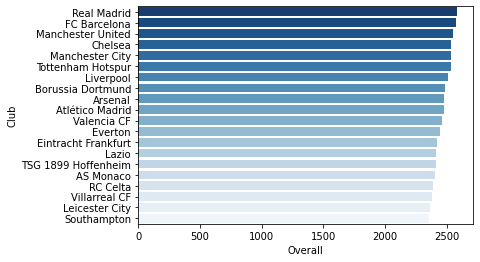

In [10]:
top_int_clubs = df.groupby(by=['Club'])['Overall'].sum().reset_index().sort_values(by=["Overall"], ascending=False).head(20)
sns.barplot(y='Club', x='Overall', data=top_int_clubs, palette=sns.color_palette("Blues_r", 20));

Top MLS teams with highest rated players. 

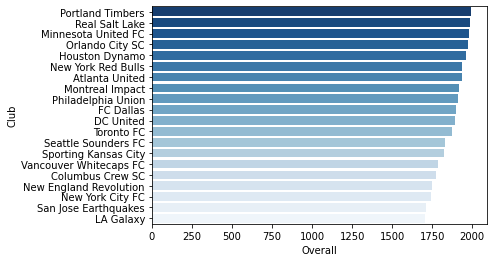

In [11]:
top_mls_clubs = MLS_df.groupby(by=['Club'])['Overall'].sum().reset_index().sort_values(by=["Overall"], ascending=False).head(20)
sns.barplot(y='Club', x='Overall', data=top_mls_clubs, palette=sns.color_palette("Blues_r", 20));

Highest rated international players. 

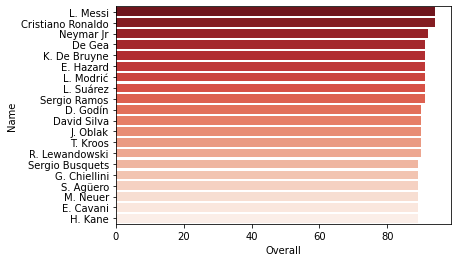

In [12]:
top_int_players = df.sort_values('Overall', ascending=False).head(20)
sns.barplot(y='Name', x='Overall', data=top_int_players, palette=sns.color_palette("Reds_r", 20));

Highest rated players. 

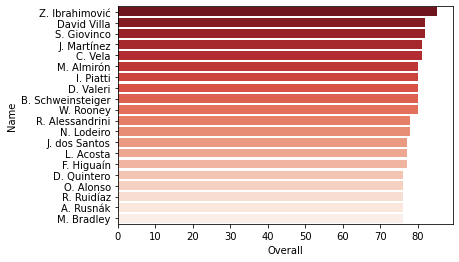

In [13]:
top_mls_players = MLS_df.sort_values('Overall', ascending=False).head(20)
sns.barplot(y='Name', x='Overall', data=top_mls_players, palette=sns.color_palette("Reds_r", 20));

Lets look at internation clubs and see with are player under their potential.

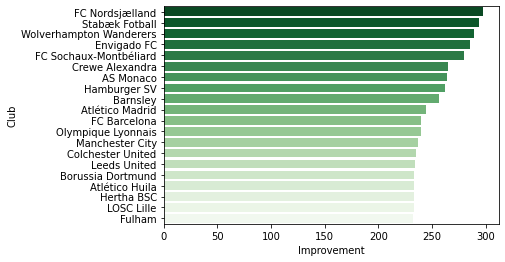

In [14]:
df['Improvement'] = df['Potential'] - df['Overall']
top_int_clubs_to_improve = df.groupby(by=['Club'])['Improvement'].sum().reset_index().\
sort_values(by=['Improvement'], ascending=False).head(20)
sns.barplot(y='Club', x='Improvement', data=top_int_clubs_to_improve, palette=sns.color_palette("Greens_r", 20));

Lets look at MLS clubs and see with are player under their potential.

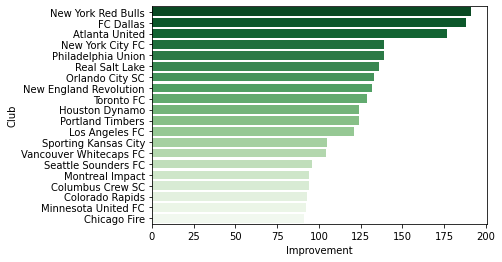

In [15]:
MLS_df['Improvement'] = MLS_df['Potential'] - MLS_df['Overall']
top_mls_clubs_to_improve = MLS_df.groupby(by=['Club'])['Improvement'].sum().reset_index().\
sort_values(by=['Improvement'], ascending=False).head(20)
sns.barplot(y='Club', x='Improvement', data=top_mls_clubs_to_improve, palette=sns.color_palette("Greens_r", 20));

#HANDLING NULL VALUES 

In [16]:
null_columns1=all_df.columns[all_df.isnull().any()]
all_df[null_columns1].isnull().sum()

Club                         241
Preferred Foot                48
International Reputation      48
Weak Foot                     48
Skill Moves                   48
Work Rate                     48
Real Face                     48
Position                      60
Height                        48
Weight                        48
Crossing                      48
Finishing                     48
HeadingAccuracy               48
ShortPassing                  48
Volleys                       48
Dribbling                     48
Curve                         48
FKAccuracy                    48
LongPassing                   48
BallControl                   48
Acceleration                  48
SprintSpeed                   48
Agility                       48
Reactions                     48
Balance                       48
ShotPower                     48
Jumping                       48
Stamina                       48
Strength                      48
LongShots                     48
Aggression

In [17]:
all_df = all_df[all_df['Position'].notnull()]
# Assign club as 'Other' for players having no club assigned here
all_df['Club'].fillna('Other', inplace=True)

# Assign most common value of preferred foot to the player where this feature is null
all_df['Preferred Foot'].fillna(all_df['Preferred Foot'].mode(), inplace=True)
all_df['Weak Foot'].fillna(all_df['Weak Foot'].mode(), inplace=True)

all_df['Skill Moves'].fillna(all_df['Skill Moves'].median(), inplace=True)
all_df['Work Rate'].fillna(all_df['Work Rate'].mode(), inplace=True)
all_df['International Reputation'].fillna(all_df['International Reputation'].median(), inplace=True)
all_df['Height'].fillna(all_df['Height'].mode(), inplace=True)
all_df['Weight'].fillna(all_df['Weight'].mode(), inplace=True)

In [18]:
null_columns1=all_df.columns[all_df.isnull().any()]
all_df[null_columns1].isnull().sum()

Release Clause    1504
dtype: int64

In [19]:
null_columns2 = MLS_df.columns[MLS_df.isnull().any()]
MLS_df[null_columns2].isnull().sum()

Release Clause    19
dtype: int64

In [20]:
null_columns3 = df.columns[df.isnull().any()]
df[null_columns2].isnull().sum()

Release Clause    1545
dtype: int64

#Property Analysis of Players of Different Positions

In [21]:
socc_stats_int = df[['Overall','Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']]

corr1 = socc_stats_int.corr()
corr1.style.background_gradient().set_precision(2)

,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
Overall,1.00,0.39,0.33,0.34,0.50,0.39,0.37,0.42,0.40,0.48,0.46,0.20,0.21,0.26,0.10,0.44,0.27,0.36,0.35,0.42,0.39,0.32,0.35,0.50,0.34,0.73,0.29,0.25,0.22
Crossing,0.39,1.00,0.65,0.47,0.81,0.69,0.86,0.83,0.76,0.76,0.84,0.67,0.65,0.70,0.62,0.70,0.14,0.67,-0.02,0.74,0.47,0.43,0.78,0.68,0.64,0.57,0.44,0.43,0.41
Finishing,0.33,0.65,1.00,0.47,0.66,0.88,0.82,0.76,0.70,0.52,0.79,0.61,0.59,0.64,0.52,0.81,0.10,0.51,-0.00,0.88,0.24,-0.02,0.89,0.70,0.84,0.53,0.02,-0.04,-0.07
HeadingAccuracy,0.34,0.47,0.47,1.00,0.64,0.51,0.55,0.44,0.41,0.51,0.66,0.33,0.38,0.26,0.16,0.61,0.38,0.63,0.49,0.51,0.69,0.55,0.53,0.28,0.55,0.51,0.58,0.56,0.53
ShortPassing,0.50,0.81,0.66,0.64,1.00,0.70,0.84,0.78,0.74,0.90,0.91,0.57,0.56,0.61,0.53,0.77,0.20,0.72,0.14,0.76,0.61,0.54,0.76,0.72,0.68,0.68,0.56,0.54,0.51
Volleys,0.39,0.69,0.88,0.51,0.70,1.00,0.81,0.81,0.75,0.57,0.79,0.57,0.56,0.62,0.51,0.83,0.13,0.53,0.04,0.87,0.33,0.09,0.85,0.70,0.83,0.59,0.12,0.07,0.03
Dribbling,0.37,0.86,0.82,0.55,0.84,0.81,1.00,0.84,0.75,0.72,0.94,0.75,0.73,0.76,0.66,0.80,0.14,0.69,-0.03,0.84,0.44,0.29,0.90,0.73,0.77,0.59,0.33,0.30,0.27
Curve,0.42,0.83,0.76,0.44,0.78,0.81,0.84,1.00,0.86,0.71,0.83,0.61,0.58,0.68,0.58,0.79,0.11,0.59,-0.03,0.83,0.40,0.27,0.81,0.74,0.75,0.61,0.29,0.26,0.23
FKAccuracy,0.40,0.76,0.70,0.41,0.74,0.75,0.75,0.86,1.00,0.71,0.76,0.50,0.47,0.59,0.52,0.75,0.09,0.54,-0.01,0.80,0.40,0.30,0.73,0.72,0.73,0.58,0.30,0.28,0.25
LongPassing,0.48,0.76,0.52,0.51,0.90,0.57,0.72,0.71,0.71,1.00,0.79,0.45,0.43,0.53,0.46,0.68,0.16,0.63,0.12,0.67,0.59,0.59,0.62,0.70,0.54,0.64,0.58,0.58,0.56


In [22]:
socc_stats_mls = MLS_df[['Overall','Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']]

corr2 = socc_stats_mls.corr()
corr2.style.background_gradient().set_precision(2)

,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
Overall,1.00,0.42,0.39,0.35,0.52,0.42,0.42,0.44,0.45,0.50,0.50,0.22,0.24,0.31,0.23,0.44,0.20,0.50,0.23,0.44,0.43,0.25,0.42,0.54,0.42,0.73,0.27,0.24,0.19
Crossing,0.42,1.00,0.69,0.50,0.79,0.72,0.86,0.87,0.76,0.68,0.84,0.63,0.60,0.73,0.69,0.74,0.06,0.66,-0.19,0.77,0.49,0.41,0.82,0.73,0.69,0.68,0.46,0.45,0.41
Finishing,0.39,0.69,1.00,0.50,0.66,0.89,0.84,0.79,0.74,0.42,0.81,0.62,0.60,0.71,0.63,0.85,0.04,0.52,-0.19,0.90,0.35,0.01,0.91,0.71,0.85,0.65,0.10,0.05,-0.02
HeadingAccuracy,0.35,0.50,0.50,1.00,0.69,0.52,0.61,0.47,0.44,0.52,0.70,0.38,0.43,0.33,0.28,0.63,0.48,0.67,0.37,0.49,0.77,0.57,0.56,0.28,0.57,0.53,0.61,0.57,0.54
ShortPassing,0.52,0.79,0.66,0.69,1.00,0.68,0.86,0.76,0.72,0.86,0.91,0.54,0.53,0.64,0.63,0.76,0.14,0.76,-0.02,0.72,0.70,0.59,0.75,0.66,0.70,0.74,0.64,0.63,0.58
Volleys,0.42,0.72,0.89,0.52,0.68,1.00,0.82,0.83,0.79,0.48,0.80,0.60,0.57,0.70,0.63,0.86,0.05,0.55,-0.16,0.88,0.41,0.10,0.87,0.70,0.83,0.68,0.18,0.14,0.08
Dribbling,0.42,0.86,0.84,0.61,0.86,0.82,1.00,0.87,0.77,0.65,0.95,0.73,0.71,0.82,0.76,0.85,0.11,0.70,-0.20,0.85,0.56,0.35,0.91,0.74,0.80,0.72,0.43,0.40,0.35
Curve,0.44,0.87,0.79,0.47,0.76,0.83,0.87,1.00,0.86,0.63,0.83,0.60,0.56,0.73,0.68,0.82,0.04,0.63,-0.20,0.87,0.47,0.30,0.85,0.77,0.78,0.72,0.36,0.34,0.28
FKAccuracy,0.45,0.76,0.74,0.44,0.72,0.79,0.77,0.86,1.00,0.61,0.77,0.46,0.42,0.62,0.60,0.79,-0.03,0.55,-0.17,0.82,0.42,0.27,0.76,0.70,0.79,0.69,0.31,0.30,0.25
LongPassing,0.50,0.68,0.42,0.52,0.86,0.48,0.65,0.63,0.61,1.00,0.72,0.31,0.30,0.44,0.47,0.57,0.07,0.66,0.02,0.54,0.63,0.66,0.52,0.60,0.49,0.68,0.66,0.68,0.64


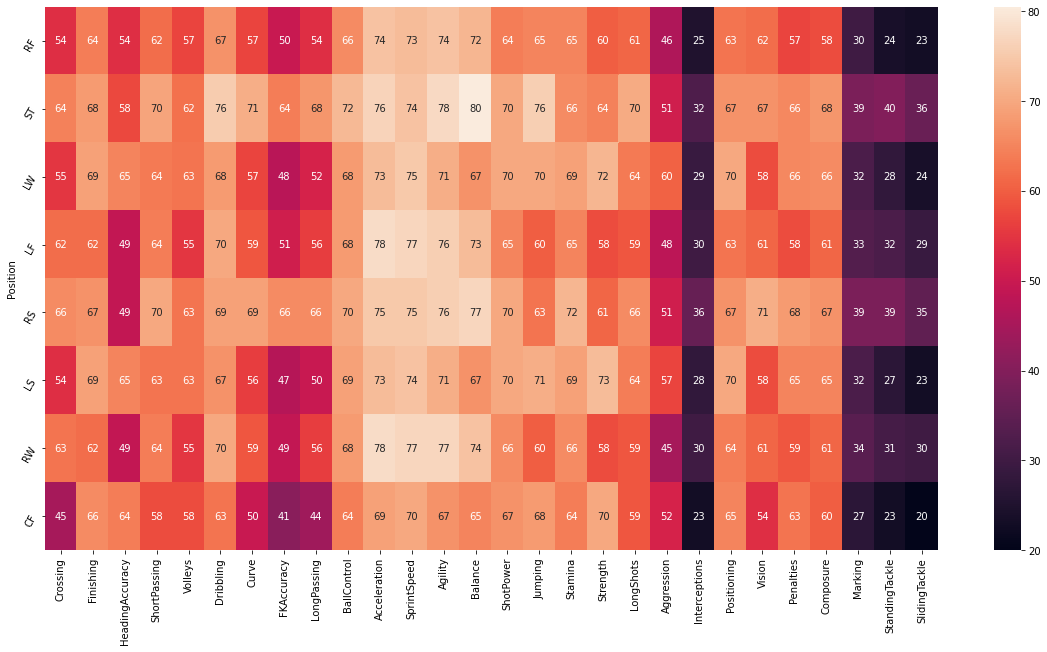

In [23]:
attributes_by_pos_df = df[df['Position_Cat'] == "Forward"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()

plt.subplots(figsize=(20, 10))

g = sns.heatmap(attributes_by_pos_df, annot=True)
g.set_yticklabels(labels=df[df['Position_Cat'] == "Forward"]["Position"].unique().tolist(), rotation=60);

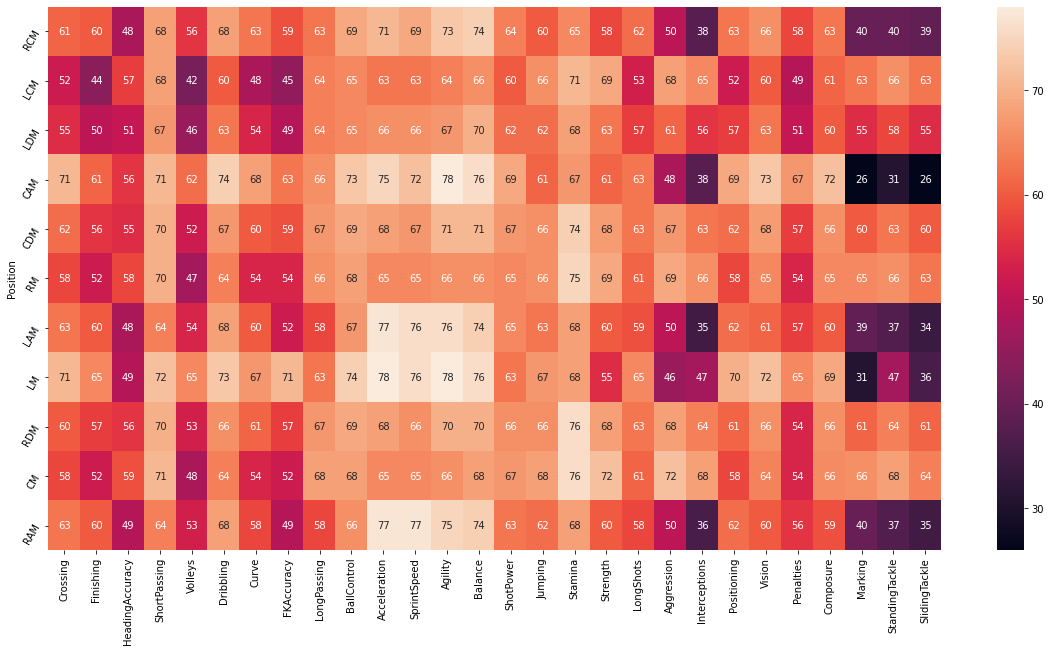

In [24]:
attributes_by_pos_int = df[df['Position_Cat'] == "Midfielder"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()

plt.subplots(figsize=(20, 10))

g = sns.heatmap(attributes_by_pos_int, annot=True)
g.set_yticklabels(labels=df[df['Position_Cat'] == "Midfielder"]["Position"].unique().tolist(), rotation=60);

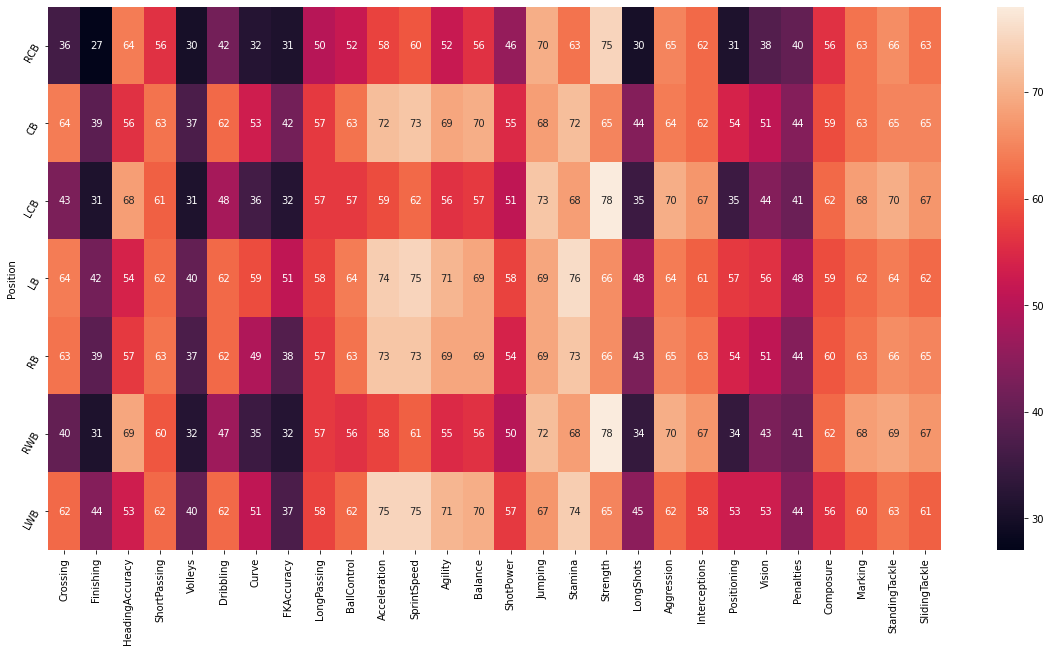

In [25]:
attributes_by_pos_int = df[df['Position_Cat'] == "Defender"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()

plt.subplots(figsize=(20, 10))

g = sns.heatmap(attributes_by_pos_int, annot=True)
g.set_yticklabels(labels=df[df['Position_Cat'] == "Defender"]["Position"].unique().tolist(), rotation=60);

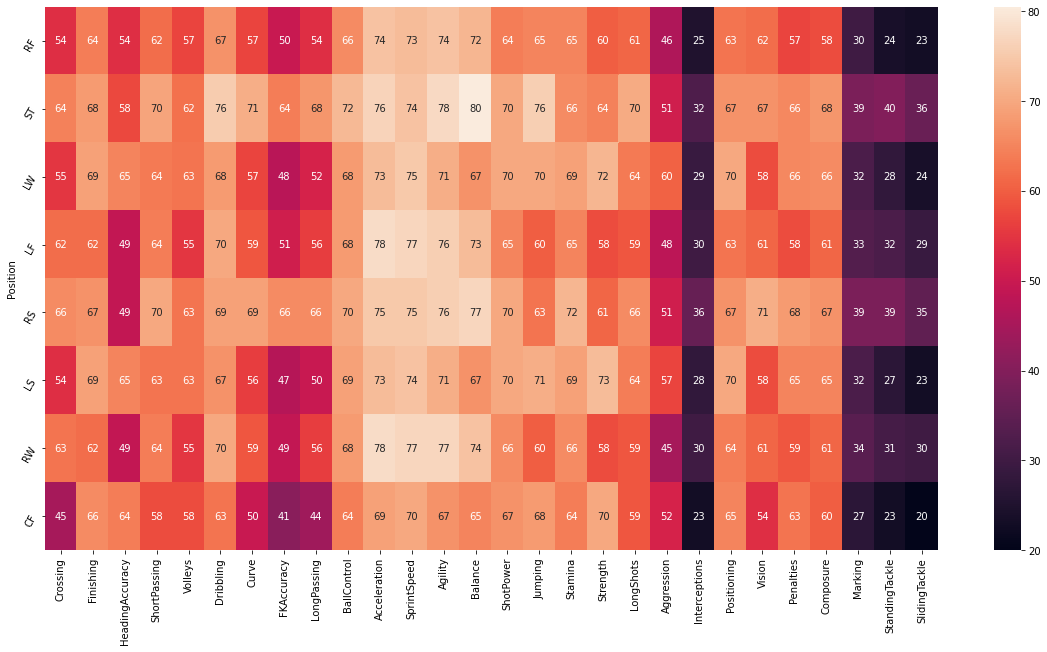

In [26]:
attributes_by_pos_int = df[df['Position_Cat'] == "Forward"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()

plt.subplots(figsize=(20, 10))

g = sns.heatmap(attributes_by_pos_int, annot=True)
g.set_yticklabels(labels=df[df['Position_Cat'] == "Forward"]["Position"].unique().tolist(), rotation=60);

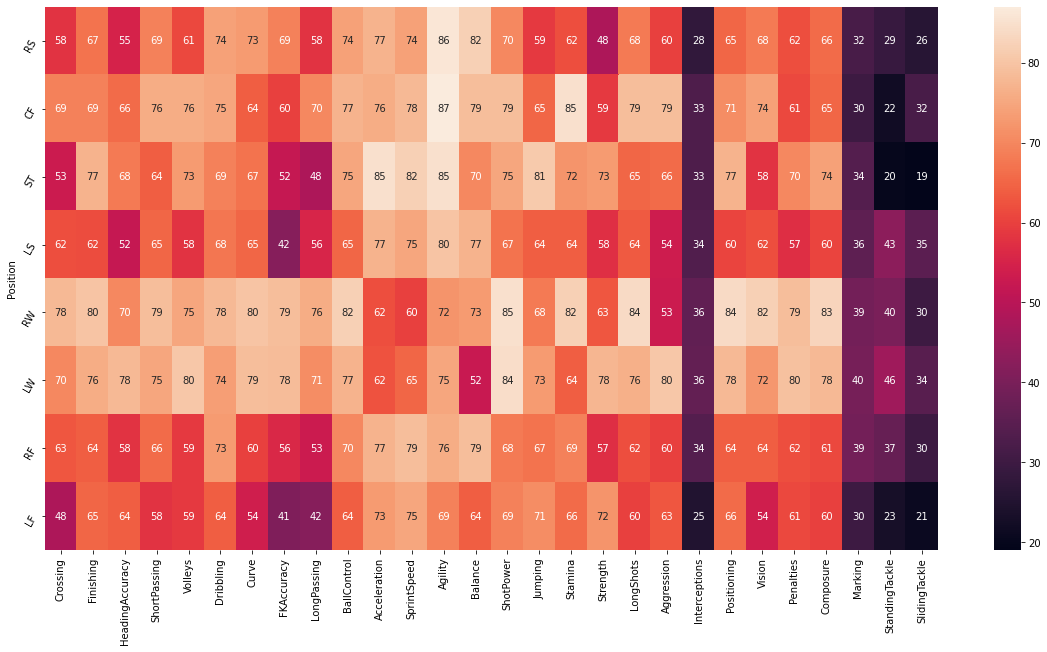

In [27]:
attributes_by_pos_mls = MLS_df[MLS_df['Position_Cat'] == "Forward"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()

plt.subplots(figsize=(20, 10))

g = sns.heatmap(attributes_by_pos_mls, annot=True)
g.set_yticklabels(labels=MLS_df[MLS_df['Position_Cat'] == "Forward"]["Position"].unique().tolist(), rotation=60);

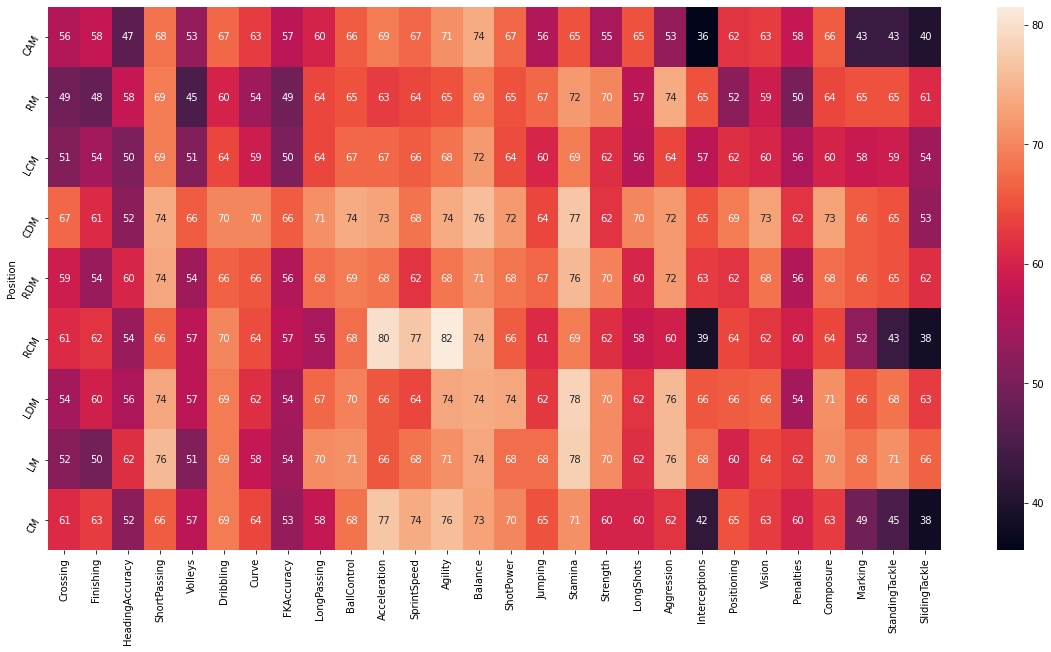

In [28]:
attributes_by_pos_mls = MLS_df[MLS_df['Position_Cat'] == "Midfielder"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()

plt.subplots(figsize=(20, 10))

g = sns.heatmap(attributes_by_pos_mls, annot=True)
g.set_yticklabels(labels=MLS_df[MLS_df['Position_Cat'] == "Midfielder"]["Position"].unique().tolist(), rotation=60);

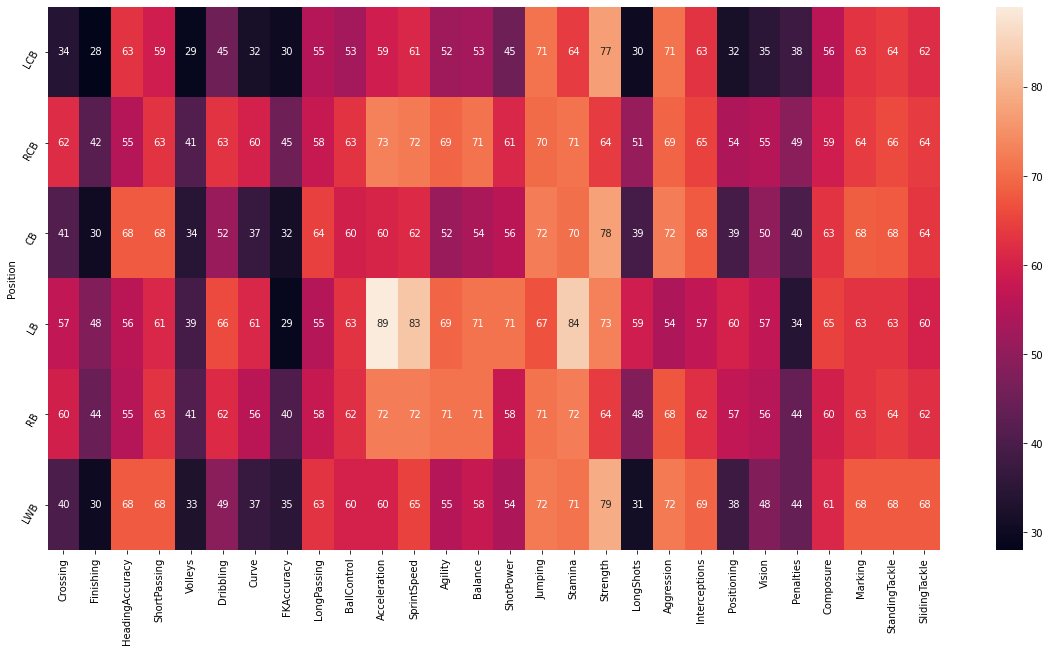

In [29]:
attributes_by_pos_mls = MLS_df[MLS_df['Position_Cat'] == "Defender"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()

plt.subplots(figsize=(20, 10))

g = sns.heatmap(attributes_by_pos_mls, annot=True)
g.set_yticklabels(labels=MLS_df[MLS_df['Position_Cat'] == "Defender"]["Position"].unique().tolist(), rotation=60);

#MLS Players which have the most potential for growth 

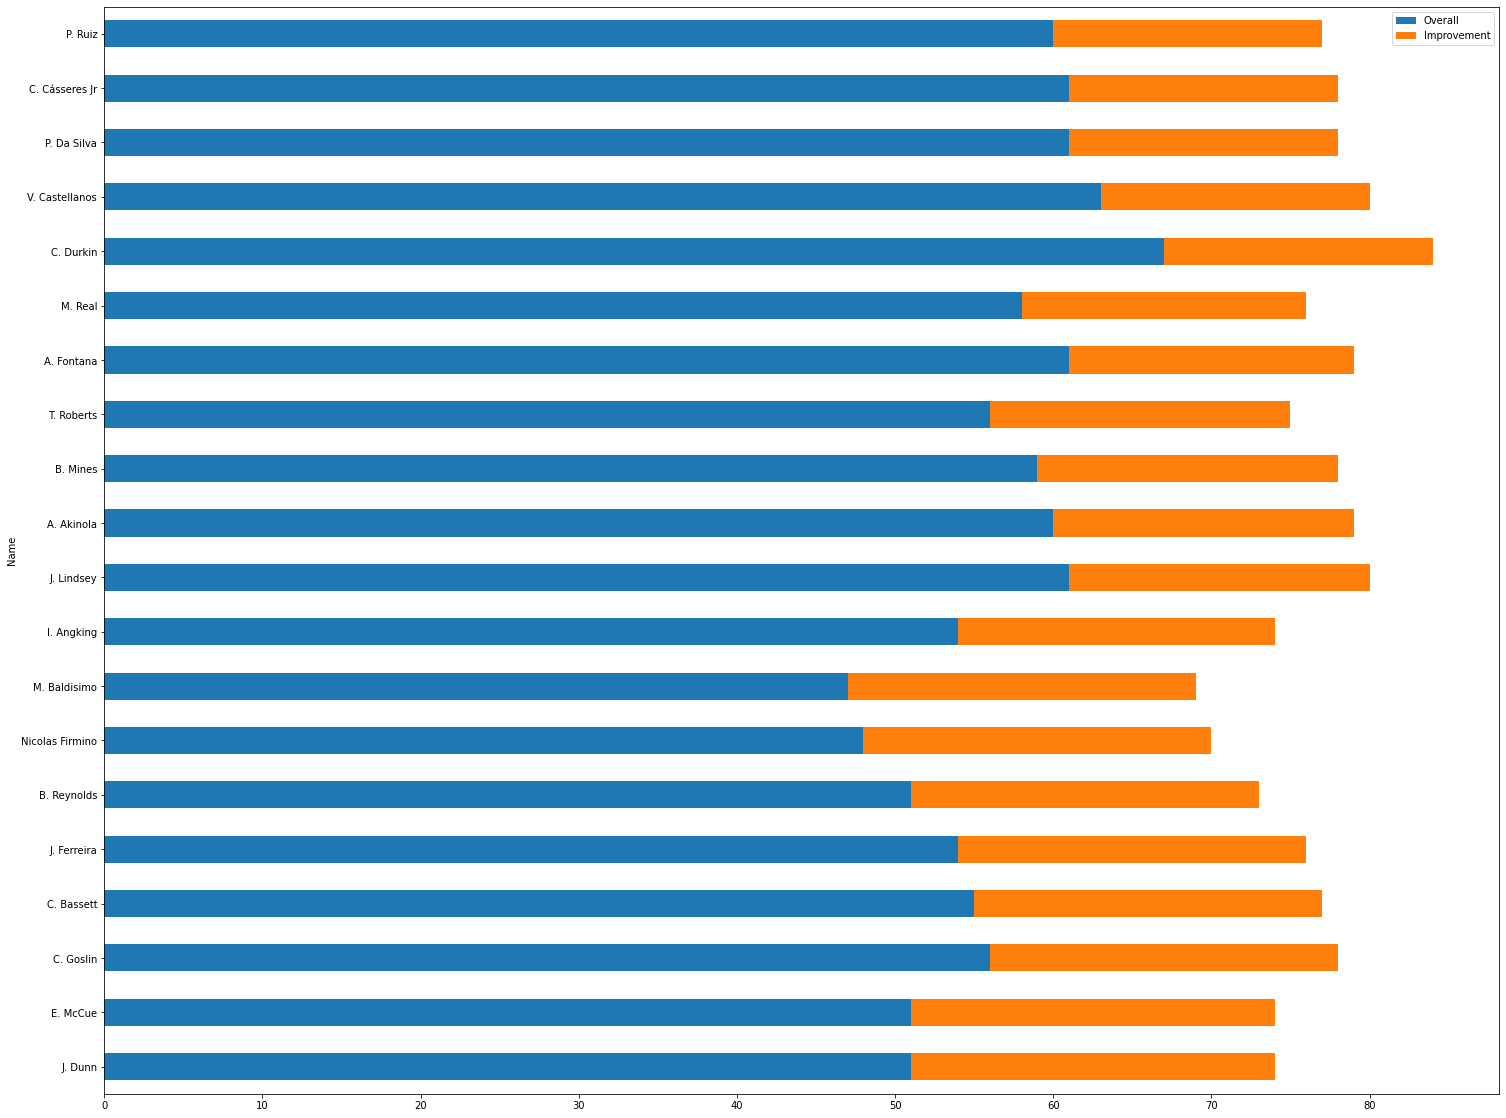

In [30]:
fig, ax = plt.subplots(figsize=(25, 20))

MLS_df_sub = MLS_df.loc[MLS_df['Improvement'].nlargest(20).reset_index()['index']][['Name', 'Overall', 'Improvement']]
MLS_df_sub.set_index('Name').plot(kind='barh', stacked=True, ax=ax, grid=False)


#Best International Players in different areas of soccer

In [31]:
feature_list = []
for col in socc_stats_int:
    feature_list.append(["Best " + col, df.loc[df[col].idxmax]["Name"]])
    
best_int_players = pd.DataFrame(feature_list, columns=["Feature", "Player"])
best_int_players.set_index('Feature')

,Player
Feature,
Best Overall,L. Messi
Best Crossing,K. De Bruyne
Best Finishing,L. Messi
Best HeadingAccuracy,Naldo
Best ShortPassing,L. Modrić
Best Volleys,E. Cavani
Best Dribbling,L. Messi
Best Curve,Quaresma
Best FKAccuracy,L. Messi


#Best MLS Players in different arts of soccer

In [32]:
feature_list = []
for col in socc_stats_mls:
    feature_list.append(["Best " + col, MLS_df.loc[MLS_df[col].idxmax]["Name"]])
    
best_mls_players = pd.DataFrame(feature_list, columns=["Feature", "Player"])
best_mls_players.set_index('Feature')

,Player
Feature,
Best Overall,Z. Ibrahimović
Best Crossing,N. Lodeiro
Best Finishing,Z. Ibrahimović
Best HeadingAccuracy,Z. Ibrahimović
Best ShortPassing,B. Schweinsteiger
Best Volleys,Z. Ibrahimović
Best Dribbling,S. Giovinco
Best Curve,S. Giovinco
Best FKAccuracy,S. Giovinco


In [33]:
refined_df = MLS_df.drop(['Nationality', 'Club', 'Age', 'Real Face', 'Value', 'Wage', 'Special', 
                      'Potential', 'Release Clause', 'Height', 'Weight','Reactions'], axis=1)
refined_df.head(10)

,ID,Name,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Position_Cat,Improvement
109,41236,Z. Ibrahimović,85,Right,5.0,4.0,5.0,Medium/ Low,RS,73.0,86.0,83.0,79.0,86.0,79.0,82.0,82.0,73.0,84.0,58.0,59.0,75.0,39.0,90.0,68.0,61.0,86.0,82.0,84.0,20.0,85.0,79.0,89.0,90.0,28.0,37.0,24.0,13.0,15.0,10.0,9.0,12.0,Forward,0
293,184431,S. Giovinco,82,Right,2.0,4.0,4.0,High/ Medium,CF,72.0,80.0,34.0,80.0,75.0,86.0,90.0,93.0,76.0,86.0,88.0,80.0,94.0,91.0,80.0,34.0,77.0,42.0,81.0,75.0,26.0,82.0,81.0,73.0,82.0,23.0,29.0,28.0,6.0,3.0,6.0,3.0,3.0,Forward,0
315,113422,David Villa,82,Right,3.0,5.0,4.0,High/ Low,ST,71.0,86.0,67.0,76.0,79.0,83.0,83.0,80.0,67.0,85.0,72.0,67.0,71.0,73.0,81.0,67.0,70.0,66.0,79.0,67.0,29.0,86.0,75.0,88.0,83.0,30.0,28.0,38.0,8.0,9.0,9.0,11.0,9.0,Forward,0
345,207877,J. Martínez,81,Right,1.0,4.0,3.0,High/ Medium,LS,53.0,84.0,77.0,68.0,73.0,75.0,68.0,57.0,55.0,78.0,89.0,92.0,91.0,90.0,79.0,86.0,72.0,73.0,65.0,66.0,20.0,84.0,58.0,70.0,75.0,20.0,20.0,15.0,12.0,14.0,14.0,12.0,8.0,Forward,3
397,169416,C. Vela,81,Left,3.0,2.0,4.0,High/ Low,RW,79.0,81.0,70.0,81.0,82.0,83.0,81.0,71.0,66.0,83.0,78.0,80.0,81.0,81.0,74.0,68.0,74.0,67.0,80.0,57.0,37.0,81.0,81.0,72.0,80.0,31.0,22.0,14.0,8.0,14.0,8.0,13.0,10.0,Forward,0
418,230977,M. Almirón,80,Left,1.0,2.0,4.0,High/ High,CAM,71.0,74.0,43.0,79.0,75.0,81.0,74.0,70.0,70.0,79.0,90.0,89.0,86.0,64.0,78.0,46.0,85.0,52.0,73.0,65.0,50.0,74.0,79.0,64.0,76.0,43.0,53.0,49.0,6.0,9.0,13.0,13.0,12.0,Midfielder,4
524,176376,I. Piatti,80,Right,2.0,4.0,5.0,High/ Medium,LW,69.0,81.0,54.0,78.0,77.0,86.0,80.0,55.0,74.0,84.0,77.0,76.0,87.0,81.0,83.0,31.0,89.0,73.0,80.0,79.0,55.0,83.0,77.0,80.0,82.0,61.0,62.0,24.0,14.0,13.0,7.0,7.0,15.0,Forward,0
528,172114,D. Valeri,80,Right,2.0,3.0,3.0,High/ Medium,RF,78.0,80.0,70.0,79.0,75.0,78.0,80.0,79.0,76.0,82.0,62.0,60.0,72.0,73.0,85.0,68.0,82.0,63.0,84.0,53.0,36.0,84.0,82.0,79.0,83.0,39.0,40.0,30.0,15.0,15.0,8.0,10.0,12.0,Forward,0
550,121944,B. Schweinsteiger,80,Right,4.0,3.0,3.0,Medium/ Medium,LCB,76.0,69.0,75.0,82.0,79.0,71.0,82.0,74.0,83.0,78.0,36.0,37.0,61.0,63.0,81.0,71.0,67.0,75.0,77.0,77.0,77.0,73.0,81.0,77.0,87.0,76.0,74.0,75.0,14.0,14.0,13.0,13.0,11.0,Defender,0
552,54050,W. Rooney,80,Right,4.0,4.0,3.0,Medium/ High,ST,77.0,80.0,75.0,81.0,83.0,74.0,84.0,83.0,82.0,80.0,65.0,65.0,66.0,77.0,85.0,74.0,74.0,78.0,80.0,81.0,56.0,80.0,82.0,81.0,86.0,57.0,55.0,40.0,10.0,11.0,13.0,8.0,7.0,Forward,0


#Preparing for the Linear Regression Model to predict Overall Rating from  features of MLS players

In [80]:
player_id = refined_df['ID']
names = refined_df['Name']
target = refined_df[['Overall']]
model_df = refined_df.drop(['ID', 'Name', 'Overall', 'Position', 'Improvement'], axis = 1)
model_df = pd.get_dummies(model_df)
model_df.head()

,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Preferred Foot_Left,Preferred Foot_Right,Work Rate_High/ High,Work Rate_High/ Low,Work Rate_High/ Medium,Work Rate_Low/ High,Work Rate_Low/ Low,Work Rate_Low/ Medium,Work Rate_Medium/ High,Work Rate_Medium/ Low,Work Rate_Medium/ Medium,Position_Cat_Defender,Position_Cat_Forward,Position_Cat_Goalkeeper,Position_Cat_Midfielder
109,5.0,4.0,5.0,73.0,86.0,83.0,79.0,86.0,79.0,82.0,82.0,73.0,84.0,58.0,59.0,75.0,39.0,90.0,68.0,61.0,86.0,82.0,84.0,20.0,85.0,79.0,89.0,90.0,28.0,37.0,24.0,13.0,15.0,10.0,9.0,12.0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
293,2.0,4.0,4.0,72.0,80.0,34.0,80.0,75.0,86.0,90.0,93.0,76.0,86.0,88.0,80.0,94.0,91.0,80.0,34.0,77.0,42.0,81.0,75.0,26.0,82.0,81.0,73.0,82.0,23.0,29.0,28.0,6.0,3.0,6.0,3.0,3.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
315,3.0,5.0,4.0,71.0,86.0,67.0,76.0,79.0,83.0,83.0,80.0,67.0,85.0,72.0,67.0,71.0,73.0,81.0,67.0,70.0,66.0,79.0,67.0,29.0,86.0,75.0,88.0,83.0,30.0,28.0,38.0,8.0,9.0,9.0,11.0,9.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
345,1.0,4.0,3.0,53.0,84.0,77.0,68.0,73.0,75.0,68.0,57.0,55.0,78.0,89.0,92.0,91.0,90.0,79.0,86.0,72.0,73.0,65.0,66.0,20.0,84.0,58.0,70.0,75.0,20.0,20.0,15.0,12.0,14.0,14.0,12.0,8.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
397,3.0,2.0,4.0,79.0,81.0,70.0,81.0,82.0,83.0,81.0,71.0,66.0,83.0,78.0,80.0,81.0,81.0,74.0,68.0,74.0,67.0,80.0,57.0,37.0,81.0,81.0,72.0,80.0,31.0,22.0,14.0,8.0,14.0,8.0,13.0,10.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


#Regression with scikit-learn
Use the dataframe with the grouped attributes for the regression model. Create 2 new dataframes for the features and the target of the regression.

The features (independent variables) are the attributes 
The target (dependent variable) is the overal player Rating.

In [35]:
X = model_df
y = target['Overall']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

In [36]:
lm.score(X,y)

0.8313058331396497

In [37]:
sk_coeffs = lm.coef_.tolist()
for attr, coef in zip(model_df, sk_coeffs):
    print("Attribute: {}, Coefficient: {}".format(attr,coef))

Attribute: International Reputation, Coefficient: 0.8149287929559753
Attribute: Weak Foot, Coefficient: 0.3060853287537738
Attribute: Skill Moves, Coefficient: 1.2626690569503636
Attribute: Crossing, Coefficient: -0.03495631005230294
Attribute: Finishing, Coefficient: 0.010843305461160737
Attribute: HeadingAccuracy, Coefficient: 0.06158567844303561
Attribute: ShortPassing, Coefficient: 0.13990023416153793
Attribute: Volleys, Coefficient: 0.003899106984754358
Attribute: Dribbling, Coefficient: -0.05505142252110449
Attribute: Curve, Coefficient: -0.030555953069292426
Attribute: FKAccuracy, Coefficient: 0.040087147183250835
Attribute: LongPassing, Coefficient: 0.0019062110850937269
Attribute: BallControl, Coefficient: 0.20649962714182546
Attribute: Acceleration, Coefficient: 0.060098273602256294
Attribute: SprintSpeed, Coefficient: -0.003872537856283681
Attribute: Agility, Coefficient: 0.028648734686875496
Attribute: Balance, Coefficient: -0.026415486275834055
Attribute: ShotPower, Coeffi

#Regression with statsmodels

This model uses the method of Ordinary Least Squares (OLS) to estimate our parameters. OLS aims to minimize the sum of the squared distances between the actual values in the dataset and the predicted values generated by the regression line.

In [38]:
sm_y = y
sm_X = X

#add a constant to the features
sm_X = sm.add_constant(X)

# use Ordinary Least Squares
OLS_model = sm.OLS(y,X).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Overall   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     59.96
Date:                Mon, 08 Mar 2021   Prob (F-statistic):          1.47e-193
Time:                        03:04:34   Log-Likelihood:                -1436.3
No. Observations:                 633   AIC:                             2971.
Df Residuals:                     584   BIC:                             3189.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
International Reputation     0.8149      0.311      2.619      0.009       0.204       1.426
Weak Foot                    0.3061      0.157      1.949      0.052      -0.002       0.615
Skill Moves                  1.2627      0.254      4.981      0.000       0.765       1.761
Crossing                    -0.0350      0.015     -2.317      0.021      -0.065      -0.005
Finishing                    0.0108      0.019      0.568      0.570      -0.027       0.048
HeadingAccuracy              0.0616      0.018      3.462      0.001       0.027       0.097
ShortPassing                 0.1399      0.027      5.107      0.000       0.086       0.194
Volleys                      0.0039      0.015      0.255      0.799      -0.026       0.034
Dribbling                   -0.0551      0.026     -2.138      0.033      -0.106      -0.004
Curve                       -0.0306      0.016     -1.924      0.055      -0.062       0.001
FKAccuracy                   0.0401      0.013      3.058      0.002       0.014       0.066
LongPassing                  0.0019      0.018      0.106      0.915      -0.033       0.037
BallControl                  0.2065      0.030      6.878      0.000       0.148       0.265
Acceleration                 0.0601      0.022      2.767      0.006       0.017       0.103
SprintSpeed                 -0.0039      0.020     -0.196      0.844      -0.043       0.035
Agility                      0.0286      0.016      1.752      0.080      -0.003       0.061
Balance                     -0.0264      0.014     -1.864      0.063      -0.054       0.001
ShotPower                   -0.0140      0.017     -0.818      0.414      -0.047       0.020
Jumping                      0.0020      0.012      0.168      0.866      -0.021       0.025
Stamina                      0.0580      0.013      4.378      0.000       0.032       0.084
Strength                     0.0398      0.014      2.866      0.004       0.013       0.067
LongShots                    0.0082      0.018      0.451      0.652      -0.028       0.044
Aggression                   0.0674      0.014      4.922      0.000       0.040       0.094
Interceptions               -0.0466      0.018     -2.572      0.010      -0.082      -0.011
Positioning                 -0.0289      0.018     -1.619      0.106      -0.064       0.006
Vision                       0.0128      0.016      0.816      0.415      -0.018       0.044
Penalties                    0.0022      0.015      0.150      0.881      -0.027       0.032
Composure                    0.1615      0.020      8.059      0.000       0.122       0.201
Marking                      0.0393      0.014      2.760      0.006       0.011       0.067
StandingTackle               0.0456      0.024      1.925      0.055      -0.001       0.092
SlidingTackle 

We see that there are high coeff scores, which lead us to believe there are some multicollinearity problems in our model. Multicollinearity occurs when your model includes multiple factors that are correlated not just to your response variable, but also to each other. In other words, it results when you have factors that are a bit redundant. We'll look further into this later.

#Predict Rating From Attributes with Machine Learning

Reuse X and y again from scikit-learn regression for our model. We will split up the dataset into training and testing data for both variables. X_train and Y_train are used to train the multiple linear regression model.

Test/train split is up to the user, but the majority of the dataset should be used to train the model. Here we will use 80% of the data for training and 20% for testing results.

In [39]:
# create training and testing data from same X and y used in regression above
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

# create and fit the model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

# generate predictions for player Rating to compare with y_test data
predictions = lm.predict(X_test)

# display first 10 results of our predicted player Ratings.
predictions

array([64.64466286, 63.34188814, 63.56119665, 63.38138968, 68.61437453,
       63.32508331, 70.94740355, 59.00283319, 69.06681972, 69.67033032,
       60.14630061, 62.64571132, 69.87810128, 66.28686062, 71.49972271,
       67.06573648, 76.7235776 , 60.79434668, 63.76922343, 62.05918178,
       65.05658007, 75.96463922, 69.17873821, 69.27697405, 61.63987633,
       72.60443074, 69.53247612, 71.57465034, 62.72698513, 84.21297928,
       59.04295781, 68.1255258 , 72.82100569, 67.13606531, 69.96293267,
       63.5777849 , 66.23195111, 62.60633793, 67.17148272, 65.31585229,
       63.05322326, 67.24636478, 70.44728698, 61.72509762, 63.8442941 ,
       60.45489062, 52.28292476, 66.19698149, 67.46321241, 61.48557706,
       65.49359956, 70.9866891 , 60.72256873, 68.29488124, 57.41775827,
       72.13158817, 56.13477632, 66.85183439, 62.97231988, 64.9496471 ,
       63.75608146, 69.30225386, 66.07471953, 70.27818893, 63.47996431,
       59.05357036, 70.65873647, 61.10911089, 61.19969012, 65.93

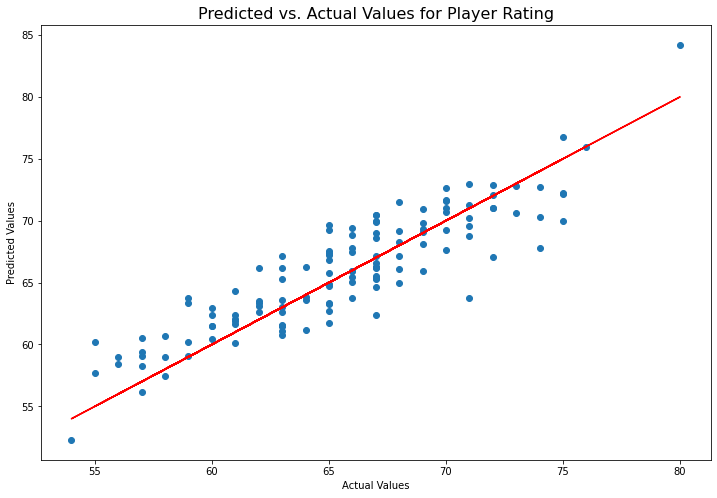

In [40]:
plt.figure(figsize=(12,8))
plt.title("Predicted vs. Actual Values for Player Rating", fontsize=16)
plt.scatter(y_test,predictions)
plt.plot(y_test, y_test, color="Red") # identity line y=x
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [41]:
print("Accuracy (scale of 0 to 1): {}".format(model.score(X_test, y_test)))

Accuracy (scale of 0 to 1): 0.7838162083980408


Since this can be considered suspiciously high accuracy score for the model, we'll check VIF scores to check for variables that are highly correlated and contain similiar information about the variance within a given dataset.

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(3)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.426,International Reputation
1,1.465,Weak Foot
2,4.186,Skill Moves
3,7.716,Crossing
4,13.899,Finishing
5,9.141,HeadingAccuracy
6,14.579,ShortPassing
7,7.826,Volleys
8,24.336,Dribbling
9,9.852,Curve


For our predictors, the VIF is greater than 1, which means the predictors may be moderately correlated. 
A VIF between 5 and 10 indicates high correlation that may be problematic. And VIF scores above 10, you can assume that the regression coefficients are poorly estimated due to multicollinearity. Our suspicions have been verified. 

#Use Clustering to identify similar MLS players to top International players

In [44]:
mls_data = refined_df.drop(['ID', 'Name', 'Position', 'Improvement'], axis = 1)
mls_data

,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Position_Cat
109,85,Right,5.0,4.0,5.0,Medium/ Low,73.0,86.0,83.0,79.0,86.0,79.0,82.0,82.0,73.0,84.0,58.0,59.0,75.0,39.0,90.0,68.0,61.0,86.0,82.0,84.0,20.0,85.0,79.0,89.0,90.0,28.0,37.0,24.0,13.0,15.0,10.0,9.0,12.0,Forward
293,82,Right,2.0,4.0,4.0,High/ Medium,72.0,80.0,34.0,80.0,75.0,86.0,90.0,93.0,76.0,86.0,88.0,80.0,94.0,91.0,80.0,34.0,77.0,42.0,81.0,75.0,26.0,82.0,81.0,73.0,82.0,23.0,29.0,28.0,6.0,3.0,6.0,3.0,3.0,Forward
315,82,Right,3.0,5.0,4.0,High/ Low,71.0,86.0,67.0,76.0,79.0,83.0,83.0,80.0,67.0,85.0,72.0,67.0,71.0,73.0,81.0,67.0,70.0,66.0,79.0,67.0,29.0,86.0,75.0,88.0,83.0,30.0,28.0,38.0,8.0,9.0,9.0,11.0,9.0,Forward
345,81,Right,1.0,4.0,3.0,High/ Medium,53.0,84.0,77.0,68.0,73.0,75.0,68.0,57.0,55.0,78.0,89.0,92.0,91.0,90.0,79.0,86.0,72.0,73.0,65.0,66.0,20.0,84.0,58.0,70.0,75.0,20.0,20.0,15.0,12.0,14.0,14.0,12.0,8.0,Forward
397,81,Left,3.0,2.0,4.0,High/ Low,79.0,81.0,70.0,81.0,82.0,83.0,81.0,71.0,66.0,83.0,78.0,80.0,81.0,81.0,74.0,68.0,74.0,67.0,80.0,57.0,37.0,81.0,81.0,72.0,80.0,31.0,22.0,14.0,8.0,14.0,8.0,13.0,10.0,Forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17905,51,Right,1.0,1.0,1.0,Medium/ Medium,11.0,6.0,14.0,19.0,5.0,7.0,12.0,12.0,25.0,13.0,33.0,25.0,39.0,28.0,19.0,34.0,21.0,56.0,8.0,24.0,11.0,6.0,37.0,10.0,39.0,5.0,13.0,14.0,54.0,47.0,51.0,50.0,54.0,Goalkeeper
17931,51,Right,1.0,3.0,2.0,Low/ High,22.0,22.0,46.0,49.0,23.0,28.0,25.0,24.0,45.0,32.0,56.0,57.0,43.0,43.0,39.0,66.0,62.0,74.0,15.0,47.0,48.0,29.0,25.0,37.0,49.0,49.0,49.0,46.0,9.0,13.0,11.0,15.0,10.0,Defender
17992,51,Right,1.0,2.0,2.0,Medium/ Medium,31.0,58.0,58.0,41.0,39.0,41.0,32.0,24.0,37.0,49.0,49.0,47.0,53.0,51.0,49.0,60.0,50.0,60.0,42.0,47.0,25.0,52.0,49.0,54.0,49.0,16.0,22.0,21.0,14.0,13.0,9.0,7.0,13.0,Forward
18170,48,Right,1.0,3.0,2.0,High/ Low,31.0,32.0,48.0,51.0,39.0,48.0,36.0,37.0,47.0,38.0,69.0,60.0,54.0,68.0,49.0,59.0,55.0,48.0,39.0,50.0,44.0,48.0,48.0,44.0,41.0,29.0,32.0,40.0,12.0,8.0,11.0,9.0,12.0,Midfielder


In [45]:
mls_data = pd.get_dummies(mls_data)
mls_data.head()

,Overall,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Preferred Foot_Left,Preferred Foot_Right,Work Rate_High/ High,Work Rate_High/ Low,Work Rate_High/ Medium,Work Rate_Low/ High,Work Rate_Low/ Low,Work Rate_Low/ Medium,Work Rate_Medium/ High,Work Rate_Medium/ Low,Work Rate_Medium/ Medium,Position_Cat_Defender,Position_Cat_Forward,Position_Cat_Goalkeeper,Position_Cat_Midfielder
109,85,5.0,4.0,5.0,73.0,86.0,83.0,79.0,86.0,79.0,82.0,82.0,73.0,84.0,58.0,59.0,75.0,39.0,90.0,68.0,61.0,86.0,82.0,84.0,20.0,85.0,79.0,89.0,90.0,28.0,37.0,24.0,13.0,15.0,10.0,9.0,12.0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
293,82,2.0,4.0,4.0,72.0,80.0,34.0,80.0,75.0,86.0,90.0,93.0,76.0,86.0,88.0,80.0,94.0,91.0,80.0,34.0,77.0,42.0,81.0,75.0,26.0,82.0,81.0,73.0,82.0,23.0,29.0,28.0,6.0,3.0,6.0,3.0,3.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
315,82,3.0,5.0,4.0,71.0,86.0,67.0,76.0,79.0,83.0,83.0,80.0,67.0,85.0,72.0,67.0,71.0,73.0,81.0,67.0,70.0,66.0,79.0,67.0,29.0,86.0,75.0,88.0,83.0,30.0,28.0,38.0,8.0,9.0,9.0,11.0,9.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
345,81,1.0,4.0,3.0,53.0,84.0,77.0,68.0,73.0,75.0,68.0,57.0,55.0,78.0,89.0,92.0,91.0,90.0,79.0,86.0,72.0,73.0,65.0,66.0,20.0,84.0,58.0,70.0,75.0,20.0,20.0,15.0,12.0,14.0,14.0,12.0,8.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
397,81,3.0,2.0,4.0,79.0,81.0,70.0,81.0,82.0,83.0,81.0,71.0,66.0,83.0,78.0,80.0,81.0,81.0,74.0,68.0,74.0,67.0,80.0,57.0,37.0,81.0,81.0,72.0,80.0,31.0,22.0,14.0,8.0,14.0,8.0,13.0,10.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [46]:
mls_data.describe()

,Overall,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Preferred Foot_Left,Preferred Foot_Right,Work Rate_High/ High,Work Rate_High/ Low,Work Rate_High/ Medium,Work Rate_Low/ High,Work Rate_Low/ Low,Work Rate_Low/ Medium,Work Rate_Medium/ High,Work Rate_Medium/ Low,Work Rate_Medium/ Medium,Position_Cat_Defender,Position_Cat_Forward,Position_Cat_Goalkeeper,Position_Cat_Midfielder
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,66.510269,1.085308,2.837283,2.375987,48.301738,45.774092,52.603476,60.344392,44.161137,55.973144,49.379147,43.203791,54.230648,58.453397,65.229068,65.080569,64.110585,63.797788,56.949447,65.537125,64.428120,66.061611,47.712480,61.497630,48.186414,50.484992,54.033175,49.189573,58.996840,48.939968,48.996840,46.554502,16.911532,16.486572,16.834123,16.592417,16.804107,0.218009,0.781991,0.094787,0.058452,0.162717,0.064771,0.001580,0.012638,0.145340,0.042654,0.417062,0.357030,0.176935,0.115324,0.350711
std,5.701180,0.371861,0.746553,0.782032,17.842284,18.927021,16.470124,13.506616,17.719311,18.565167,19.153651,17.702120,13.884943,16.301009,14.579973,14.908629,15.465982,15.003698,17.732380,11.477370,15.402561,11.728643,18.892252,15.994968,19.576287,19.333438,13.691117,15.381501,10.603617,19.607692,20.514891,20.150320,17.632009,16.771082,17.063062,16.952225,17.770144,0.413220,0.413220,0.293152,0.234781,0.369399,0.246316,0.039746,0.111796,0.352722,0.202236,0.493463,0.479503,0.381916,0.319665,0.477570
min,47.000000,1.000000,1.000000,1.000000,6.000000,4.000000,8.000000,15.000000,5.000000,6.000000,6.000000,7.000000,16.000000,9.000000,19.000000,16.000000,22.000000,20.000000,10.000000,30.000000,21.000000,31.000000,6.000000,14.000000,6.000000,4.000000,11.000000,10.000000,23.000000,5.000000,9.000000,6.000000,4.000000,3.000000,5.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.000000,1.000000,2.000000,2.000000,36.000000,31.000000,47.000000,57.000000,31.000000,51.000000,36.000000,30.000000,47.000000,55.000000,58.000000,57.000000,54.000000,55.000000,47.000000,59.000000,57.000000,59.000000,33.000000,55.000000,29.000000,39.000000,47.000000,38.000000,52.000000,34.000000,31.000000,27.000000,8.000000,8.000000,9.000000,8.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,67.000000,1.000000,3.000000,2.000000,53.000000,49.000000,56.000000,64.000000,46.000000,61.000000,53.000000,42.000000,57.000000,63.000000,68.000000,68.000000,67.000000,67.000000,62.000000,67.000000,68.000000,67.000000,53.000000,66.000000,55.000000,56.000000,56.000000,51.000000,60.000000,57.000000,59.000000,55.000000,11.000000,11.000000,12.000000,11.000000,11.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,1.000000,3.000000,3.000000,62.000000,61.000000,64.000000,69.000000,58.000000,68.000000,65.000000,57.000000,64.000000,68.000000,75.000000,76.000000,75.000000,75.000000,70.

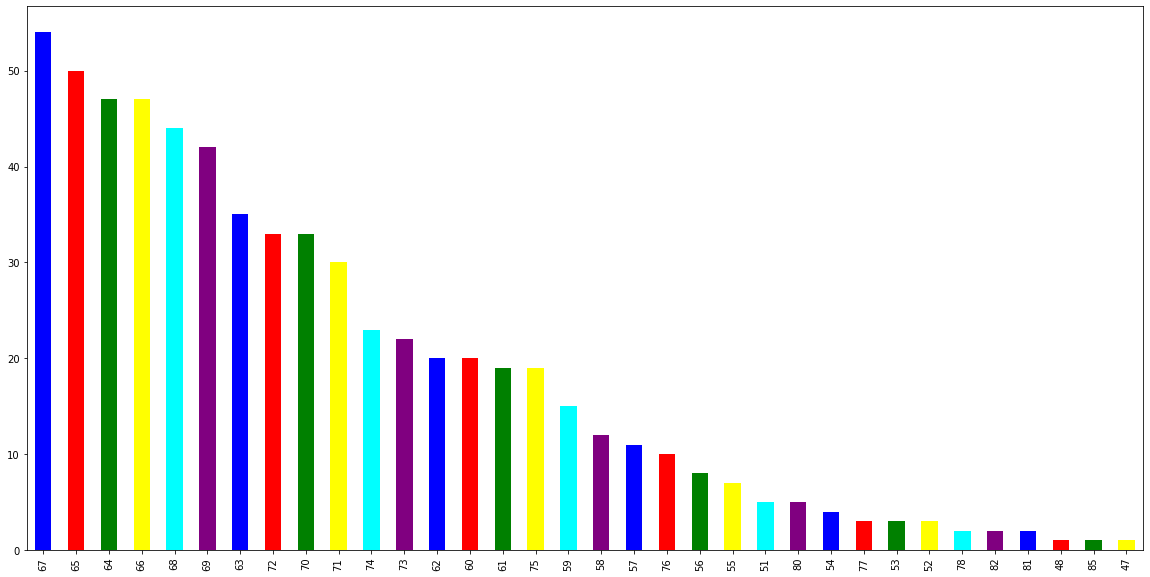

In [47]:
#Visualize column overall_rating of the dataframe
mls_data['Overall'].value_counts()

mls_data['Overall'].value_counts().plot(kind='bar',figsize=(20,10),color=['blue', 'red', 'green', 'yellow', 
                                                                          'cyan', 'purple'])

Features more than 32 are not so important so we will consider only 32 features for further preprocessing of the data.

In [48]:
#Split dataframe into df_x and df_y
df_x = mls_data.drop(['Overall'], 1)
df_y = np.array(mls_data['Overall'])

In [50]:
#Use RandomForestRegressor to check feature_importances
rfc_1 = RandomForestRegressor(random_state=10)
rfc_1.fit(df_x, df_y)

feature_importances = pd.DataFrame({'feature':df_x.columns,'importance':np.round(rfc_1.feature_importances_,4)})
feature_importances = feature_importances.sort_values('importance',ascending=False).set_index('feature')

In [87]:
print(feature_importances[:33])

                 importance
feature                    
Composure            0.3523
BallControl          0.1921
StandingTackle       0.0471
Interceptions        0.0419
Marking              0.0395
GKReflexes           0.0380
Positioning          0.0371
GKHandling           0.0292
GKDiving             0.0259
Aggression           0.0194
Stamina              0.0186
Strength             0.0162
HeadingAccuracy      0.0146
GKPositioning        0.0132
Finishing            0.0107
ShotPower            0.0093
SprintSpeed          0.0084
Dribbling            0.0083
Vision               0.0079
Volleys              0.0075
SlidingTackle        0.0073
ShortPassing         0.0070
Jumping              0.0064
Crossing             0.0052
Acceleration         0.0048
GKKicking            0.0037
LongShots            0.0037
Agility              0.0037
LongPassing          0.0034
Penalties            0.0028
FKAccuracy           0.0027
Balance              0.0025
Curve                0.0022


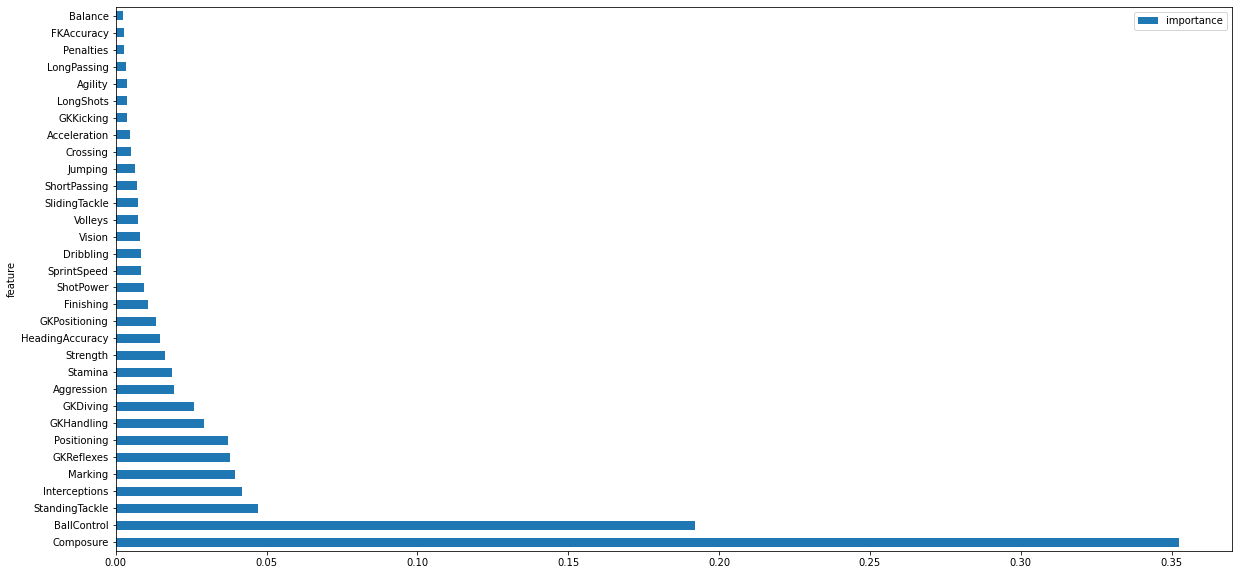

In [88]:
#Visualize top features of the dataframe
feature_importances[:32].plot(kind='barh',figsize=(20,10))

In [54]:
x, x_test, y, y_test = train_test_split(df_x,df_y,test_size=0.2,train_size=0.8, random_state = 55)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.20,train_size =0.80, random_state = 55)

In [55]:
from sklearn.preprocessing import StandardScaler, Normalizer, scale
df_x1 = scale(x_train)

Perfrom PCA (dimensionality reduction technique) on scaled dataframe

In [56]:
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
# on non-standardized data

pca = PCA(n_components=10).fit(x_train)

In [57]:
pca.explained_variance_ratio_

array([0.61448756, 0.17267911, 0.04893155, 0.03799586, 0.02344409,
       0.01056615, 0.00987889, 0.00808327, 0.00761172, 0.00628082])

In [58]:
from sklearn.decomposition import PCA

# on non-standardized data
df_x2 = pca.transform(x_train)

Map test and cross-validation

In [59]:
pca.transform(x_test)

array([[-55.58622877, -19.83536685,   1.2825576 , ...,  -1.17933149,
         -8.47412939,   0.47006103],
       [-88.53479952,   7.51205683,  47.15652662, ...,   3.77457831,
          1.5436429 ,  -8.89555903],
       [-19.87838292, -34.9760338 ,  12.93976196, ...,   9.48679382,
        -13.15797204,  -2.65402977],
       ...,
       [-15.99948796, -58.52765413,  10.68692629, ...,   4.70502583,
         10.22529148,  -4.59530326],
       [ -8.37149322, -79.06004112,  -0.33237593, ...,  -2.14121607,
        -23.70821083, -11.12040906],
       [ 21.94410966,  46.13191213, -31.71768617, ...,  -3.46259095,
         11.39565737, -14.40752395]])

In [60]:
pca.transform(x_cv)

array([[ 56.75055806, -70.23522287, -19.47357761, ...,  -1.06395145,
         -8.03621123,  -5.40877868],
       [-26.38094567,  40.41230047,  -7.86359702, ...,  -0.23887013,
          0.46753495,  -5.82397613],
       [ -2.24976159, -23.75787586, -12.58393381, ...,   9.04521549,
         -0.59929048, -17.35914462],
       ...,
       [-33.3870162 , -33.19877304,  21.68430853, ...,  -0.6131052 ,
         21.38275699,  -0.48932655],
       [-49.61991386,  62.59739259,   8.75127567, ...,  -5.03065652,
         -9.82743246, -12.16754546],
       [-63.44709546,  52.6912647 ,  27.21030651, ...,  12.77281352,
         -2.15868232,  -0.15888179]])

#Apply Different Models (Linear regression, Decision tree, Random forest and XGboost)

In [61]:
#Apply linear regression model on the dataset
lr1 = LinearRegression()
lr = RFE(lr1, 20)
lr.fit(x_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=20, step=1, verbose=0)

In [62]:
#Apply decision tree model on the dataset
d_tree = DecisionTreeRegressor(min_samples_split=10, random_state=55)
d_tree.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=55, splitter='best')

In [63]:
#Apply Random Forest model on the dataset
rfc = RandomForestRegressor(random_state=99)
rfc.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=99, verbose=0, warm_start=False)

In [64]:
#Apply xgboost model on the dataset
Boosting = xgb.XGBRegressor(n_estimators=200,learning_rate=1)
Boosting.fit(x_train,y_train)

[03:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [66]:
models = pd.DataFrame(index=['train_mse','cv_mse','test_mse','accuracy_score'], 
                      columns=['linear_regression','decision_tree','random_forest', 'xgboost'])

In [67]:
models.loc['train_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_train), y_true=y_train)
models.loc['cv_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_cv), y_true=y_cv)
models.loc['test_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_test), y_true=y_test)
models.loc['accuracy_score','linear_regression'] = accuracy_score(y_pred=lr.predict(x_test).round(), y_true=y_test)

In [68]:
models.loc['train_mse','decision_tree'] = mean_squared_error(y_pred=d_tree.predict(x_train), y_true=y_train)
models.loc['cv_mse','decision_tree'] = mean_squared_error(y_pred=d_tree.predict(x_cv), y_true=y_cv)
models.loc['test_mse','decision_tree'] = mean_squared_error(y_pred=d_tree.predict(x_test), y_true=y_test)
models.loc['accuracy_score','decision_tree'] = accuracy_score(y_pred=d_tree.predict(x_test).round(), y_true=y_test)

In [69]:
models.loc['train_mse','random_forest'] = mean_squared_error(y_pred=rfc.predict(x_train), y_true=y_train)
models.loc['cv_mse','random_forest'] = mean_squared_error(y_pred=rfc.predict(x_cv), y_true=y_cv)
models.loc['test_mse','random_forest'] = mean_squared_error(y_pred=rfc.predict(x_test), y_true=y_test)
models.loc['accuracy_score','random_forest'] = accuracy_score(y_pred=rfc.predict(x_test).round(), y_true=y_test)

In [71]:
models.loc['train_mse','xgboost'] = mean_squared_error(y_pred=Boosting.predict(x_train), y_true=y_train)
models.loc['cv_mse','xgboost'] = mean_squared_error(y_pred=Boosting.predict(x_cv), y_true=y_cv)
models.loc['test_mse','xgboost'] = mean_squared_error(y_pred=Boosting.predict(x_test), y_true=y_test)
models.loc['accuracy_score','xgboost'] = accuracy_score(y_pred=Boosting.predict(x_test).round(), y_true=y_test)

In [72]:
models

,linear_regression,decision_tree,random_forest,xgboost
train_mse,7.26719,0.813729,0.472008,2.96378e-07
cv_mse,8.32322,4.85487,2.30263,7.65528
test_mse,7.78142,7.4102,2.9552,5.93676
accuracy_score,0.15748,0.188976,0.204724,0.165354


Observing the above table, random forest model is providing highest accuracy and lowest mean squared error. So Random forest is best model to predict players rating.

CLUSTERING SIMILAR PLAYERS 

In [73]:
new_df = all_df[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']]


new_df

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0
18203,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0
18204,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0
18205,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0


In [74]:
from sklearn.preprocessing import StandardScaler
new_df_std = StandardScaler().fit_transform(new_df)
from sklearn.mixture import GaussianMixture
gmm_model = GaussianMixture(n_components=4).fit(new_df_std)
gmm_model.predict(new_df_std)
all_df['cluster'] = gmm_model.predict(new_df_std)

In [76]:
def player(x):
    
    cluster = all_df[all_df['Name'] == x]['cluster'].item()
    df_2 = all_df[(all_df['cluster'] == cluster) & ~(all_df['Name'] == x)][['Name', 'Age', 'Position', 'Club', 'Overall']]
    df_3 = df_2[df_2['Club'].isin(mls_teams)]
    display(df_3.head(10))

In [77]:
for p in ['L. Messi', 'De Gea', 'M. Salah', 'G. Chiellini', 'N. Kanté']:
    print("10 similar players for {}".format(p))
    player(p)

10 similar players for L. Messi


,Name,Age,Position,Club,Overall
109,Z. Ibrahimović,36,RS,LA Galaxy,85
293,S. Giovinco,31,CF,Toronto FC,82
315,David Villa,36,ST,New York City FC,82
345,J. Martínez,25,LS,Atlanta United,81
397,C. Vela,29,RW,Los Angeles FC,81
418,M. Almirón,24,CAM,Atlanta United,80
524,I. Piatti,33,LW,Montreal Impact,80
528,D. Valeri,32,RF,Portland Timbers,80
552,W. Rooney,32,ST,DC United,80
852,N. Lodeiro,29,CAM,Seattle Sounders FC,78


10 similar players for De Gea


,Name,Age,Position,Club,Overall
1621,Z. Steffen,23,GK,Columbus Crew SC,75
1798,A. Blake,27,GK,Philadelphia Union,75
2092,T. Melia,32,GK,Sporting Kansas City,74
2288,L. Robles,34,GK,New York Red Bulls,74
2805,B. Hamid,27,GK,DC United,73
2975,B. Guzan,33,GK,Atlanta United,73
3538,S. Frei,32,GK,Seattle Sounders FC,72
3603,T. Howard,39,GK,Colorado Rapids,72
4640,N. Rimando,39,GK,Real Salt Lake,71
4770,D. Ousted,33,GK,DC United,70


10 similar players for M. Salah


,Name,Age,Position,Club,Overall
109,Z. Ibrahimović,36,RS,LA Galaxy,85
293,S. Giovinco,31,CF,Toronto FC,82
315,David Villa,36,ST,New York City FC,82
345,J. Martínez,25,LS,Atlanta United,81
397,C. Vela,29,RW,Los Angeles FC,81
418,M. Almirón,24,CAM,Atlanta United,80
524,I. Piatti,33,LW,Montreal Impact,80
528,D. Valeri,32,RF,Portland Timbers,80
552,W. Rooney,32,ST,DC United,80
852,N. Lodeiro,29,CAM,Seattle Sounders FC,78


10 similar players for G. Chiellini


,Name,Age,Position,Club,Overall
1768,I. Opara,29,RCB,Sporting Kansas City,75
1847,G. Kashia,30,RCB,San Jose Earthquakes,75
2007,Fontàs,28,CB,Sporting Kansas City,75
2050,L. González Pirez,26,LCB,Atlanta United,75
2170,M. Besler,31,LCB,Sporting Kansas City,74
2205,M. Hedges,28,RCB,FC Dallas,74
2227,L. Sané,31,LCB,Orlando City SC,74
2559,K. Waston,30,RCB,Vancouver Whitecaps FC,74
3016,A. Long,25,RCB,New York Red Bulls,73
3182,T. Parker,25,CB,New York Red Bulls,73


10 similar players for N. Kanté


,Name,Age,Position,Club,Overall
550,B. Schweinsteiger,33,LCB,Chicago Fire,80
1046,J. dos Santos,28,LCM,LA Galaxy,77
1365,S. Taïder,26,LCM,Montreal Impact,76
1540,M. Bradley,30,CDM,Toronto FC,76
1563,O. Alonso,32,RDM,Seattle Sounders FC,76
1611,F. Gutiérrez,27,LCM,Sporting Kansas City,75
1686,B. Feilhaber,33,RCM,Los Angeles FC,75
1715,A. Ring,27,CDM,New York City FC,75
2040,H. Medunjanin,33,LDM,Philadelphia Union,75
2047,A. Silva,28,RW,Montreal Impact,75
